<div style="background: #F0FAFF; border-radius: 3px; padding: 10px;">
<h3> This notebook walks us through how to compute a tuning curve using the Allen Brain Observatory data and explores correlations between simultaneously recorded neurons</h3>


This notebook has three parts.  The first walks through computing a tuning curves for cells in response to a drifting grating stimulus. This is a classic single-cell analysis, and we will compare the tuning of several cells from the same experiment. The second part looks at correlations between cells that have the same tuning to the drifting grating stimulus from the same experiment. This highlights the fact that our dataset has populations of cells, simultaneously imaged, and allows for examinations of how those cells interact with each other. The third part leverages the fact that there are multiple stimuli being used in these experiments, and compares whether pairs of neurons with correlated responses to drifting gratings also have correlated responses to natural movies.

### Standard Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import sys, os

### Brain Observatory set up

In [2]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

manifest_file = '../data/allen-brain-observatory/visual-coding-2p/manifest.json'
boc = BrainObservatoryCache(manifest_file=manifest_file)

## Computing tuning curve for the drifting grating stimulus

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>We need:

<li>fluorescence trace for our cell.  We will use the DF/F trace
<li>stimulus information for the drifting grating stimulus

</div>

<div style="border-radius: 3px; padding: 10px;  background: #F0FAFF; ">

<h4>What is DF/F?</h4>
<p>We measure the fluorescence of each neuron... actually, we measure the fluorescence of each pixel. Pixels get grouped into "ROIs" (regions of interest), putative neurons, that we identify based on shape. We average the pixels in an ROI together to get the fluorescence of that ROI (or cell). There are then a couple of steps we take to clean this up before we can use it for analysis: 

<li> Most of the fluorescence is from the cell itself, but some of it is scattered fluorescence from neighboring cells or "neuropil" - processes of other cells that pass through the tissue. We do a neuropil subtraction step that estimates the amount of contamination of each ROI from the surrounding neuropil and subtracts that from the trace.
<li> Sometimes (not often, but enough) two ROIs can partly overlap. For the overlapping pixels, we are able to demix the portion of the signal that is from cell A and the portion that is from cell B. Again, this reduces contamination.
<br>
    <br>
    After we've removed these sources of contamination, we have the "corrected fluorescence" of a cell. However, what we are interested in is the metric of neural activity. So we compute "DF/F." This is the change (delta) in fluorescence normalized by the baseline fluorescence. This has been shown to relate to the firing rate of the neuron. One thing to consider is that there are lots of ways to calculate DF/F - mostly depending on how one defines the baseline flourescence. We calculate the baseline fluorescence using a median filter with a width of 180s. 
    </p>
</div>

In [3]:
cell_id = 541513979

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
I've created a function here that will return the DF/F trace and the stimulus table if we provide a cell id and a stimulus name. This function leverages functions in the AllenSDK, and there are examples that walk through these steps in other notebooks on the SDK page. I'm happy to explain the steps in greater detail if anyone is interested.  
<p>The key things to know about this.  You provide the function with a cell_specimen_id and a stimulus name.  It returns:
<li>the timestamps for the DF/F trace.  This is a numpy array.
<li>the trace of that cell's DF/F trace for the whole session.  This is also a numpy array.
<li>a table that describes the stimulus conditions and timing.  This is a <b>pandas</b> dataframe.
</div>

In [4]:
def get_dff_traces_and_stim_table(cell_specimen_id, stimulus): 
    #identify the session for a given cell id and stimulus
    exps = boc.get_ophys_experiments(cell_specimen_ids=[cell_specimen_id], stimuli=[stimulus])
    
    #get the session_id for that session
    session_id = exps[0]['id']
    
    #access the data for that session
    data_set = boc.get_ophys_experiment_data(session_id)
    
    #get the DFF trace for the cell
    timestamps, dff = data_set.get_dff_traces(cell_specimen_ids=[cell_specimen_id])
    dff_trace = dff[0,:]
    
    #get the stimulus table for the stimulus
    stim_table = data_set.get_stimulus_table(stimulus)
    
    #return everything
    return (timestamps, dff_trace, stim_table)

In [5]:
timestamps, dff_trace, stim_table = get_dff_traces_and_stim_table(cell_id, 'drifting_gratings')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
First let's plot the DF/F trace of our cell to see what it looks like
</div>

Text(0, 0.5, 'DFF')

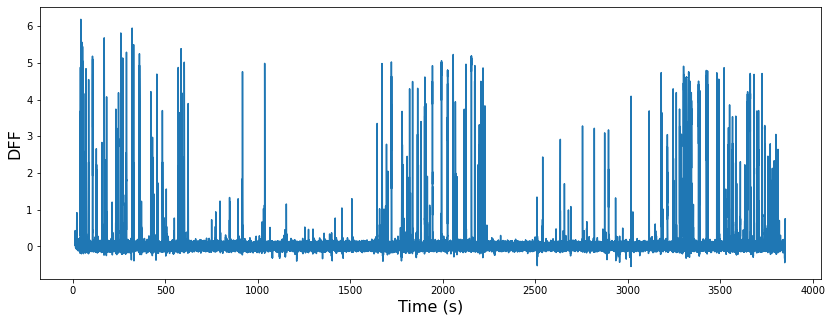

In [6]:
plt.figure(figsize=(14,5))
plt.plot(timestamps, dff_trace)
plt.xlabel("Time (s)", fontsize=16)
plt.ylabel("DFF", fontsize=16)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
Now let's look at our stimulus table to see what information we have. We just want to see the first few lines, so use the function <b>head</b> to see the top of this DataFrame.
</div>

In [7]:
stim_table.head()

,temporal_frequency,orientation,blank_sweep,start,end
0,1.0,45.0,0.0,736,796
1,15.0,90.0,0.0,826,886
2,1.0,270.0,0.0,917,977
3,NaN,NaN,1.0,1007,1067
4,4.0,90.0,0.0,1098,1158


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
The stimulus table has 5 columns.  Start and end indicate the <b>frame number</b> when a given grating condition starts and ends, respectively. The other columns indicate what the grating codition is, including the temporal frequency of the grating (in Hz), the direction (called orientation) of the grating (in degrees), and whether the grating is a blank sweep (eg. a gray screen). 
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
Pandas is a very useful python module for data analysis, which has an object called a <b>DataFrame</b> that is a flexible and powerful tool for analyzing large datasets. I highly encourage interested students to explore this analysis module. But for our purposes, we will only use it to access the stimulus information. 
</div>

<div style="border-radius: 3px; padding: 10px;  background: #F0FAFF; ">
    <h3> Pandas</h3>
    <b>A quick pandas tutorial for our purposes today!</b>
<p>
To access data from a DataFrame we must specify the column we are using and specify the row using the <b>index</b>. To specify a column we can use two methods:
<li> stim_table['start']
<li> stim_table.start
<p> Then to specify the row we want we must use the index of that row. 
<li> stim_table['start'][0]
<li> stim_table.start[0]
<p> We can also subselect portions of the DataFrame using the values in the DataFrame. For example, to select only the rows of the table where the orientation is 90 degrees we can use:
<li> stim_table[stim_table.orientation==90]
<p>Try this yourself.  Note the index.  The rows of this subselected DataFrame maintain the indices of the original DataFrame. Now in order to get a specific row, you either need to know it's original index, or use <b>iloc</b>. For example, this will return the first row of the subselected DataFrame regardless of the original index of that row:
<li> stim_table[stim_table.orientation==90].iloc[0]
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
To look at the cell's response to a given grating presentation, let's plot the DF/F of the cell during the presentation of that grating.  We want to pad the plot with ~ 1 second of the DF/F trace preceding the grating presentation.  1 second = 30 frames.  We'll plot the response to the first grating presentation.
<div>

Text(0.5, 0, 'Frames')

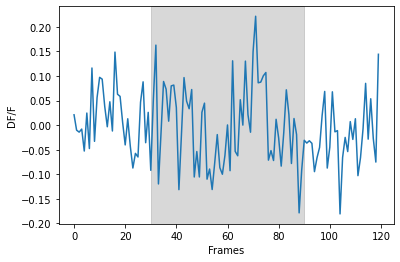

In [8]:
plt.plot(dff_trace[stim_table.start[0]-30:stim_table.end[0]+30])
plt.axvspan(30,90, color='gray', alpha=0.3) #this shades the period when the stimulus is being presented
plt.ylabel("DF/F")
plt.xlabel("Frames")

We want to quantify this response. We can explore different methods of quantifying this.
* mean DF/F during the grating presentation
* sum of the DF/F during the grating presentation (are these different?)
* maximum DF/F during grating

For now let's use the mean DF/F during the presentation of the grating.

In [9]:
dff_trace[stim_table.start[0]:stim_table.end[0]].mean()

-0.0020014683

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 1:** Repeat this for the next grating stimulus </div>

Text(0.5, 0, 'Frames')

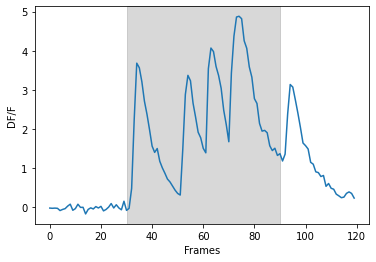

In [10]:
plt.plot(dff_trace[stim_table.start[1]-30:stim_table.end[1]+30])
plt.axvspan(30,90, color='gray', alpha=0.3) #this shades the period when the stimulus is being presented
plt.ylabel("DF/F")
plt.xlabel("Frames")

In [11]:
dff_trace[stim_table.start[1]:stim_table.end[1]].mean()

2.292613

<div style="background: #eab6f0; border-radius: 3px; padding: 10px;">
    <b>Section 1</b>
    </div

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

Already we can see that some stimulus conditions elicit larger responses than others.  This is what we want to quantify. 

<p><p>To do this, let's calculate the mean DF/F for each grating presentation in this stimulus. To start, let's create a numpy array to hold our calculated responses for each trials. We'll have three columns, one for the stimulus orientation, one for the stimulus temporal frequency, and the last for the cell's response. Then we need to iterate over all stimulus trials, populate the orientation and TF and then calculate the mean response.
    
</div>

In [12]:
cell_response= np.zeros((len(stim_table),3))
for i in range(len(stim_table)):
    cell_response[i,0] = stim_table.orientation[i]
    cell_response[i,1] = stim_table.temporal_frequency[i]
    cell_response[i,2] = dff_trace[stim_table.start[i]:stim_table.end[i]].mean()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
If we only care about one stimulus parameter, we can quickly compare the response to that parameter, say the direction. Here we will plot each grating response as a function of the grating orientation.
</div>

Text(0, 0.5, 'Mean DF/F')

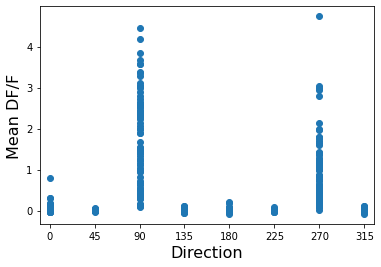

In [13]:
plt.plot(cell_response[:,0], cell_response[:,2], 'o')
plt.xticks(range(0,360,45))
plt.xlim(-10,325)
plt.xlabel("Direction", fontsize=16)
plt.ylabel("Mean DF/F", fontsize=16)

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 2:** Repeat this for the temporal frequency parameter </div>

Text(0, 0.5, 'Mean DF/F')

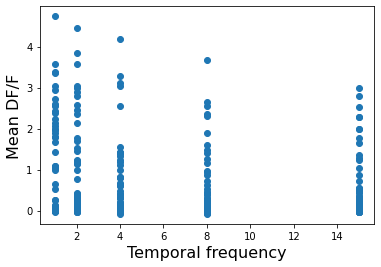

In [14]:
plt.plot(cell_response[:,1], cell_response[:,2], 'o')
plt.xlabel("Temporal frequency", fontsize=16)
plt.ylabel("Mean DF/F", fontsize=16)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
We want to quantify this more explicitly.  So let's average all of the responses to each orientation together. This is the mean DF/F response to an orientation, for all temporal frequencies, for all trials.  For example, for orientation=270: (Hint: use np.where)
</div>

In [15]:
trials = np.where(cell_response[:,0]==270)[0]
cell_response[trials,2].mean()

0.9247032543023427

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 3:** Compute and plot the mean response as a function of orientation (averaged across all temporal frequencies)
<p> To start, you need to know what all the possible orientation values are. You can find this by identifying the <b>unique</b> values that are not NaNs (eg. values that are <b>finite</b>)
</div>

In [16]:
all_ori = np.unique(cell_response[:,0])
orivals = all_ori[np.isfinite(all_ori)]
print(orivals)

[  0.  45.  90. 135. 180. 225. 270. 315.]


In [17]:
tuning = np.empty((8))
for i, ori in enumerate(orivals):
    trials = np.where(cell_response[:,0]==ori)[0]
    tuning[i] = cell_response[trials,2].mean()

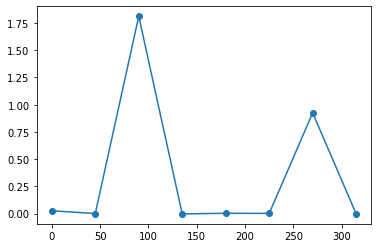

In [18]:
plt.plot(orivals,tuning, 'o-')

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 4:** Compute and plot the mean response as a function of temporal frequency (averaged across all orientations). </div>

In [19]:
tfvals = np.unique(cell_response[:,1])
tfvals = tfvals[np.isfinite(tfvals)]
print(tfvals)

[ 1.  2.  4.  8. 15.]


In [20]:
tuning_tf = np.empty((len(tfvals)))
for i,tf in enumerate(tfvals):
    trials = np.where(cell_response[:,1]==tf)
    tuning_tf[i] = cell_response[trials,2].mean()

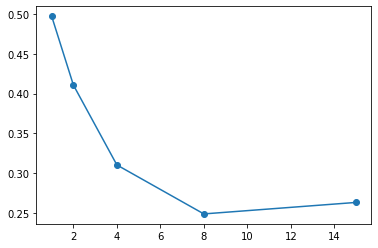

In [21]:
plt.plot(tfvals, tuning_tf, 'o-')

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 5:** Add errorbars to the above tuning curves. They can be standard deviation or standard error or the mean.  (Hint: plt.errorbar might be a useful function).
</div>

In [22]:
tuning = np.empty((8,2))
for i, ori in enumerate(orivals):
    trials = np.where(cell_response[:,0]==ori)[0]
    tuning[i,0] = cell_response[trials,2].mean()
    tuning[i,1] = cell_response[trials,2].std()

<ErrorbarContainer object of 3 artists>

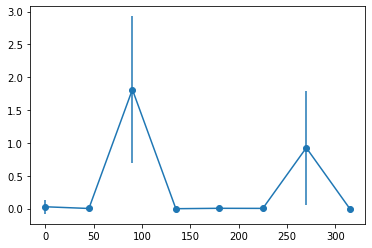

In [23]:
plt.errorbar(orivals, tuning[:,0], yerr=tuning[:,1], fmt='o-')

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
**Exercise 6:** Add a black line showing the mean response to the blank sweep.
<br>(Hint 1: orientation and temporal frequency are NaN for the blank sweep condition.  Hint 2: <b>plt.axhline</b> is a useful function for adding a horizontal line).  </div>

In [24]:
blank_trials = np.isnan(cell_response[:,0])
blank_mean = cell_response[blank_trials,2].mean()
print(blank_mean)

0.019221892748991477


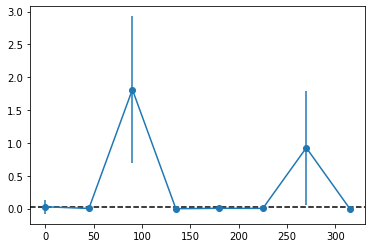

In [25]:
plt.errorbar(orivals, tuning[:,0], yerr=tuning[:,1], fmt='o-')
plt.axhline(y=blank_mean, ls='--', color='k')

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 7:** Compute and plot the direction tuning curve separately for each of the 5 temporal frequencies. Likewise, plot the temporal frequency tuning curve for each of the 8 directions. </div>

In [26]:
tuning_array = np.empty((8,5))
for i,tf in enumerate(tfvals):
    tf_trials = np.where(cell_response[:,1]==tf)[0]
    subset = cell_response[tf_trials]
    for j,ori in enumerate(orivals):
        trials = np.where(subset[:,0]==ori)
        tuning_array[j,i] = subset[trials,2].mean()        

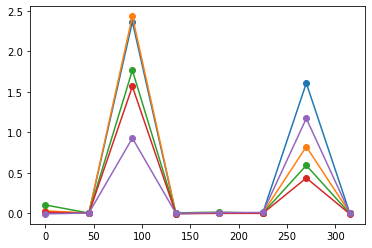

In [27]:
for i in range(5):
    plt.plot(orivals, tuning_array[:,i], 'o-')

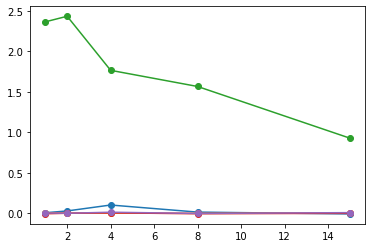

In [28]:
for i in range(8):
    plt.plot(tfvals, tuning_array[i,:], 'o-')

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 8:** Are there other ways to visualize these tuning responses that will show both orientation and temporal frequency? </div>

Text(0, 0.5, 'Direction')

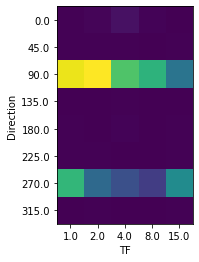

In [29]:
plt.imshow(tuning_array)
plt.xticks(range(5), tfvals)
plt.yticks(range(8), orivals)
plt.xlabel("TF")
plt.ylabel("Direction")

Let's save this figure to the results folder!

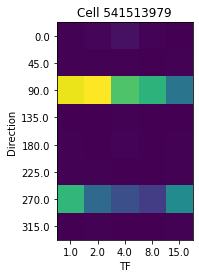

In [30]:
plt.imshow(tuning_array)
plt.xticks(range(5), tfvals)
plt.yticks(range(8), orivals)
plt.xlabel("TF")
plt.ylabel("Direction")
plt.title("Cell "+str(cell_id))
plt.savefig("/results/Cell "+str(cell_id)+".jpg")

<div style="background: #eab6f0; border-radius: 3px; padding: 10px;">
    <b>Section 2</b>
    </div

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
We've looked at the tuning curve for one cell. There are a lot of other cells in this experiment. Now we're going to see what some of the other cells in this experiment look like, and start the explore how the different cells might interact.

</div>

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 9:** Compute and plot the tuning curves for cell_ids 541512490, 541512611, 541512645, 541512079, 541511403, 541511670, 541511373, 541513771, 541511385, 541512607. (Hint: it might be helpful to write a function) In what ways do these tuning curves differ? In what ways are they the same? What are interesting parameters of a cell's response to this stimulus? 
</div>

In [31]:
def compute_ori_tf_tuning(cell_id):
    timestamps, dff_trace, stim_table = get_dff_traces_and_stim_table(cell_id, 'drifting_gratings')
    
    cell_response= np.zeros((len(stim_table),3))
    for i in range(len(stim_table)):
        cell_response[i,0] = stim_table.orientation[i]
        cell_response[i,1] = stim_table.temporal_frequency[i]
        cell_response[i,2] = dff_trace[stim_table.start[i]:stim_table.end[i]].mean()
        
    tuning_array = np.empty((8,5))
    for i,tf in enumerate(tfvals):
        tf_trials = np.where(cell_response[:,1]==tf)[0]
        subset = cell_response[tf_trials]
        for j,ori in enumerate(orivals):
            trials = np.where(subset[:,0]==ori)
            tuning_array[j,i] = subset[trials,2].mean() 
    
    plt.imshow(tuning_array)
    plt.xticks(range(5), tfvals)
    plt.yticks(range(8), orivals)
    plt.xlabel("TF")
    plt.ylabel("Direction")
    plt.title("Cell "+str(cell_id))
    plt.show()
    plt.savefig("/results/Cell "+str(cell_id)+".jpg")
    
    return tuning_array

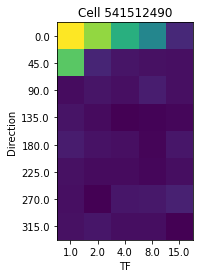

<Figure size 432x288 with 0 Axes>

In [32]:
tuning_a = compute_ori_tf_tuning(541512490)

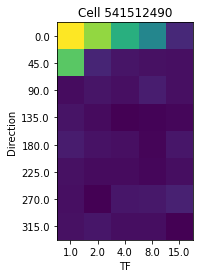

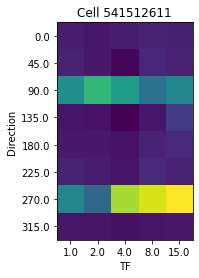

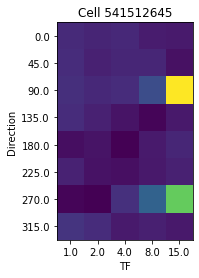

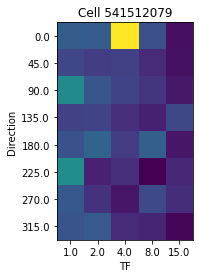

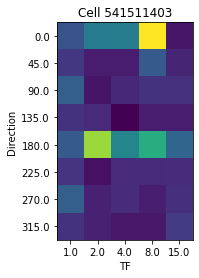

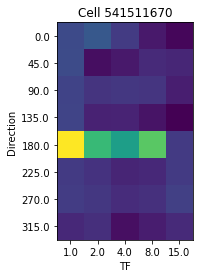

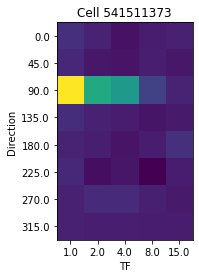

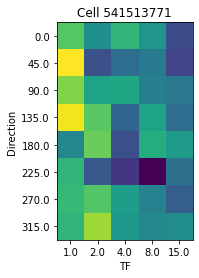

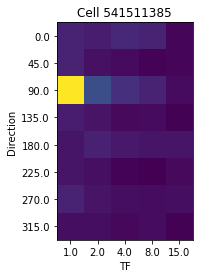

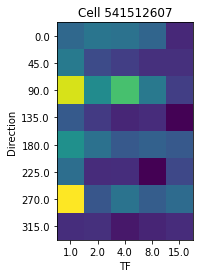

<Figure size 432x288 with 0 Axes>

In [33]:
cells = [541512490, 541512611, 541512645, 541512079, 541511403, 541511670, 541511373, 541513771, 541511385, 541512607]
for cell_id in cells:
    compute_ori_tf_tuning(cell_id)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
Some of these cells show the same tuning for orientation and temporal frequency. Now let's look at these more closely to see how they are <i>correlated</i>.

    
<p>If you've overwritten the dff_trace, go back and get the trace for our original cell: cell_id = 541513979
<p>Also get the trace for cell 541511905, let's call this trace "dff_trace_2"
</div style>

In [34]:
cell_id = 541513979
timestamps, dff_trace, stim_table = get_dff_traces_and_stim_table(cell_id, 'drifting_gratings')

In [35]:
new_cell_id = 541511905
timestamps, dff_trace_2, stim_table = get_dff_traces_and_stim_table(new_cell_id, 'drifting_gratings')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
These two cells have some similarities in their tuning preferences, but how similar are their responses?
</div>

<div style="border-radius: 3px; padding: 10px;  background: #F0FAFF; ">
<h3>Correlations</h3>
<p>
We can compute a correlation coefficient to measure the relationship between two variables - in this case the responses of two different cells. When cell A has a large response, does cell B also have a strong response? 
<p> We will use Pearson correlation coefficient, which is defined as:
    <br>
<img src="correlation_coefficient_formula.svg">
<p> where x and y are the two variables in question. We will use a function from scipy.stats to compute this for us.
<p> If the two variables are positively correlated, a large response from cell A will be matched with a large response in cell B. If they are weakly correlated, the response size of cell A will have not relationship with the response size of cell B. And if they are negatively correlated, cell B will have small responses when cell A has large responses.
<br><img src="pearson-2-small.png">
</div>

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 10:** Compute the correlation between these two cells' dff traces. We're going to use st.pearsonr from scipy.stats</div>

In [36]:
import scipy.stats as st

In [37]:
r,p = st.pearsonr(dff_trace, dff_trace_2)
print(r)

0.5628775961334622


<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 11:** Calculate the response of the second cell to all the stimulus trials and compute the correlation between these two cells' trial responses.
</div>

In [38]:
cell_response_2 = np.zeros((len(stim_table),3))
for i in range(len(stim_table)):
    cell_response_2[i,0] = stim_table.orientation[i]
    cell_response_2[i,1] = stim_table.temporal_frequency[i]
    cell_response_2[i,2] = dff_trace_2[stim_table.start[i]:stim_table.end[i]].mean()

In [39]:
r,p = st.pearsonr(cell_response[:,2], cell_response_2[:,2])
print(r)

0.7640585294224912


<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 12:** Calculate the orientation tuning curve for the second cell and compute the correlation between these two cells' tuning. Hint: you will need to <b>flatten</b> the tuning array.
</div>

In [40]:
tuning_array_2 = np.empty((8,5))
for i,tf in enumerate(tfvals):
    tf_trials = np.where(cell_response_2[:,1]==tf)[0]
    subset = cell_response_2[tf_trials]
    for j,ori in enumerate(orivals):
        trials = np.where(subset[:,0]==ori)
        tuning_array_2[j,i] = subset[trials,2].mean() 

In [41]:
r,p = st.pearsonr(tuning_array.flatten(), tuning_array_2.flatten())
print(r)

0.9347812227928617


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
We've looked at three different correlations. Discuss why these correlations are different and what it might tell you about these two cells.
    
</div style>

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 13:** Repeat these three correlation computations for cells 541511373 and 541511385. Notice anything similar or different from the previous pair?
</div>

In [42]:
cell_id = 541511373
timestamps, dff_trace_3, stim_table = get_dff_traces_and_stim_table(cell_id, 'drifting_gratings')
cell_id = 541511385
timestamps, dff_trace_4, stim_table = get_dff_traces_and_stim_table(cell_id, 'drifting_gratings')


In [43]:
r,p = st.pearsonr(dff_trace_3, dff_trace_4)
print(r)

0.05903301704433057


In [44]:
cell_response_3 = np.zeros((len(stim_table),3))
cell_response_4 = np.zeros((len(stim_table),3))
for i in range(len(stim_table)):
    cell_response_3[i,0] = stim_table.orientation[i]
    cell_response_3[i,1] = stim_table.temporal_frequency[i]
    cell_response_3[i,2] = dff_trace_3[stim_table.start[i]:stim_table.end[i]].mean()
    cell_response_4[i,2] = dff_trace_4[stim_table.start[i]:stim_table.end[i]].mean()

In [45]:
r,p = st.pearsonr(cell_response_3[:,2], cell_response_4[:,2])
print(r)

0.44830092124999266


In [46]:
tuning_array_3 = np.empty((8,5))
tuning_array_4 = np.empty((8,5))
for i,tf in enumerate(tfvals):
    tf_trials = np.where(cell_response_2[:,1]==tf)[0]
    subset3 = cell_response_3[tf_trials]
    subset4 = cell_response_4[tf_trials]
    for j,ori in enumerate(orivals):
        trials = np.where(subset3[:,0]==ori)
        tuning_array_3[j,i] = subset3[trials,2].mean()
        tuning_array_4[j,i] = subset4[trials,2].mean()

In [47]:
r,p = st.pearsonr(tuning_array_3.flatten(), tuning_array_4.flatten())
print(r)

0.8847589199012095


<div style="background: #eab6f0; border-radius: 3px; padding: 10px;">
    <b>Section 3</b>
    </div

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

Everything so far has looked at the responses of these cells to 'driftings_gratings'. Now let's look at their responses to 'natural_movie_three' and see how it compares to their grating responses.

</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
Use the function from the start of this notebook to get the timestamps, dff trace, and stimulus table for our original cell (cell_id = 541513979) for 'natural_movie_three'. Look at the stimulus table. How is it different from the stimulus table for drifting gratings?
</div style>

In [48]:
cell_id = 541513979
timestamps, dff_trace, stim_table_nm = get_dff_traces_and_stim_table(cell_id, 'natural_movie_three')

In [49]:
stim_table_nm.head()

,frame,start,end,repeat
0,0,19746,19747,0
1,1,19747,19748,0
2,2,19748,19749,0
3,3,19749,19750,0
4,4,19750,19751,0


In [50]:
stim_table_nm.repeat.unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
The movie is repeated 10 times. Each repeat begins when frame 0 is presented. Find the start times for each movie repeat.
</div style>

In [51]:
start_times = stim_table_nm[stim_table_nm.frame==0].start.values
start_times

array([19746, 23367, 26987, 30608, 34229, 75869, 79490, 83110, 86731,
       90353])

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
Now we're going to average each cell's response to the movie. Start from the start time you just found above. The movie is 3600 frames long (you can check that by finding how many unique frames there are in the stimulus table). So make an array that is size (10,3600) and put the response of the cell for each of the 10 trials in the array. Then average across those 10 trials. Do this for both of the two cells we looked at in exercises 10-12.
</div style>

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 14:** Compute the average response for cell 541513979 to natural movie three.
</div>

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 15:** Compute the average response for cell 541511905 to natural movie three. The two cells have similar tuning curves for their drifting grating responses (see above). Do you expect they have similar responses for the natural movie? Why or why not? Compute the correlation between the averaged movie responses of these two cells. How does it compare to the correlation of their tuning to the drifting gratings? Why might they be similar? Why might they be different?
</div>

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 16:** Do the same comparison for the second pair of cells that you looked at for the drifting gratings, cells 541511373 and 541511385.
</div>

<div style="background: #fcdc83; border-radius: 3px; padding: 10px;">
For an extra challenge, what is the relationship between the correlation of grating responses to the correlation of movie responses across the whole population? To do this, you'll want to get the traces for all of the cells in the experiment. Look at our function at the beginning called get_dff_traces_and_stim_table(). If you use some of the code in there, and change the get_dff_traces line to:
    
> timestamps, dff = data_set.get_dff_traces()

you will get an array of the DFF traces of all of the cells. From there you can calculate tuning for all the cells and calculate the pairwise correlations. What do you expect the result to be?
    
</div style>